# 금공프3 Final

20249433 MFE 최재필

In [152]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## 1. Mean-Variance Optimization

In [139]:
asset = pd.read_csv('it.csv')
asset.set_index('Date', inplace=True)
asset.head() # 다행히 데이터에 nan이 없다.

,AAPL,GOOG,MSFT,IBM,T
Date,,,,,
2018-01-02,169.714086,1065.00,84.484767,147.537554,36.382354
2018-01-03,169.684530,1082.48,84.877948,151.593043,35.542180
2018-01-04,170.472706,1086.40,85.624992,154.663355,35.872586
2018-01-05,172.413591,1102.23,86.686581,155.418977,36.004748
2018-01-08,171.773197,1106.94,86.775047,156.356330,36.108590


In [146]:
asset.shape

(232, 5)

### (1) `MVportfolio` 

In [188]:
def MVportfolio(asset, mu_p):
    asset_2d = asset.to_numpy()

    X = np.log(asset_2d[1:]/asset_2d[:-1]) # 수익률 (수익률은 log 차분 수익률로 계산)
    Q = np.cov(X.T) # 공분산 행렬
    r = np.nanmean(X, axis=0).reshape(-1, 1) # 기대값 (수익률 평균)
    l = np.ones(r.shape) # 1 벡터
    zero = np.zeros(l.shape) # 0 벡터

    # 라그랑지안 편미분 방정식 행렬
    Q_l_r = np.hstack([Q, l, r]) # 목적함수 편미분 
    l_0_0 = np.hstack([l.T, [[0]], [[0]]]) # 제약조건 1: 가중치 합 = 1
    r_0_0 = np.hstack([r.T, [[0]], [[0]]]) # 제약조건 2: 수익률 = mu_p

    L = np.vstack([Q_l_r, l_0_0, r_0_0]) # 완성된 라그랑지안 

    zero_l_mu = np.vstack([zero, [[0]], [[mu_p]]]) # 우변
    L_inv = np.linalg.inv(L) # 역행렬 계산

    w_lmda1_lmda2 = L_inv @ zero_l_mu # 라그랑지안 해벡터

    w = w_lmda1_lmda2[:-2] # 최적 포트폴리오 가중치
    lmda1 = w_lmda1_lmda2[-2] # 라그랑지안 해벡터 람다1
    lmda2 = w_lmda1_lmda2[-1] # 라그랑지안 해벡터 람다2

    var = w.T @ Q @ w # 최적 포트폴리오 분산

    return w, var

### (2) Efficient Frontier

In [189]:
mu_p_min = -0.001
mu_p_max = 0.001

mu_p_range = np.linspace(mu_p_min, mu_p_max, 100)

In [190]:
asset_2d = asset.to_numpy()

X = np.log(asset_2d[1:]/asset_2d[:-1]) # 수익률 (수익률은 log 차분 수익률로 계산)
r = np.nanmean(X, axis=0).reshape(-1, 1) # 기대값 (수익률 평균)

In [191]:
w_var = [MVportfolio(asset, mu_p) for mu_p in mu_p_range]
var_ret = np.array([(var, w.T @ r) for w, var in w_var]).reshape(len(w_var), 2)

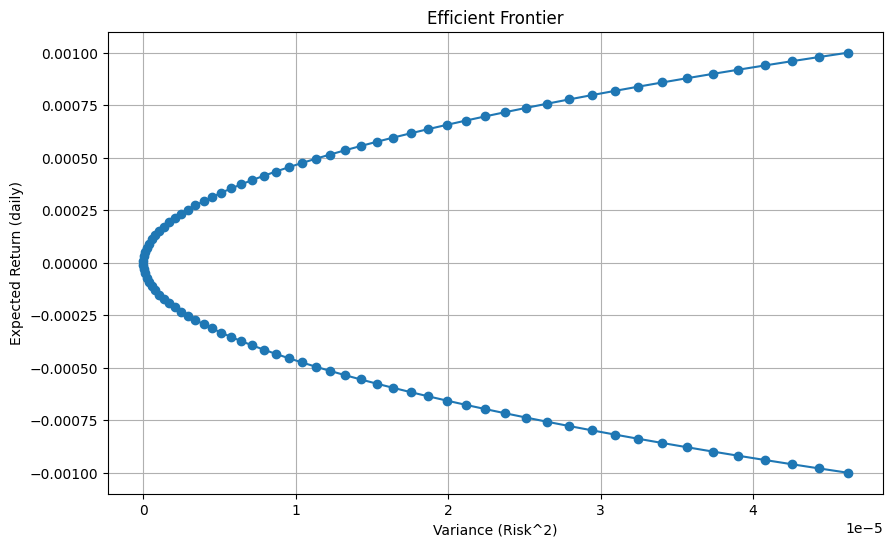

In [193]:
# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(var_ret[:, 0], var_ret[:, 1], marker='o', linestyle='-')

plt.title('Efficient Frontier')
plt.xlabel('Variance (Risk^2)')
plt.ylabel('Expected Return (daily)')
plt.grid(True)
plt.show()

## 2. Momentum

## 3. Monte-Carlo Simulation